In [1]:
# IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

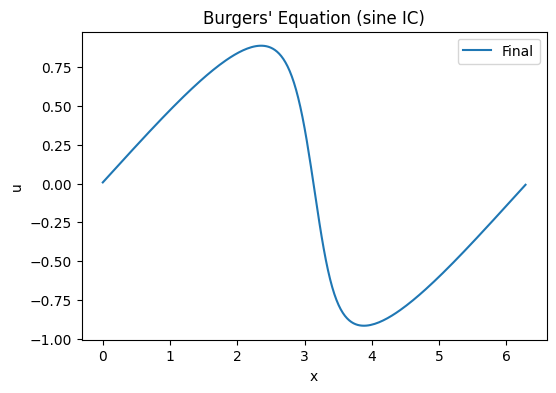

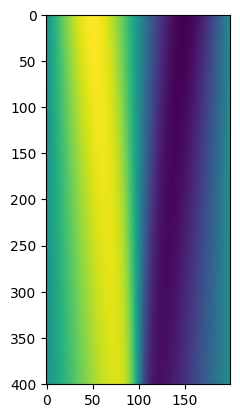

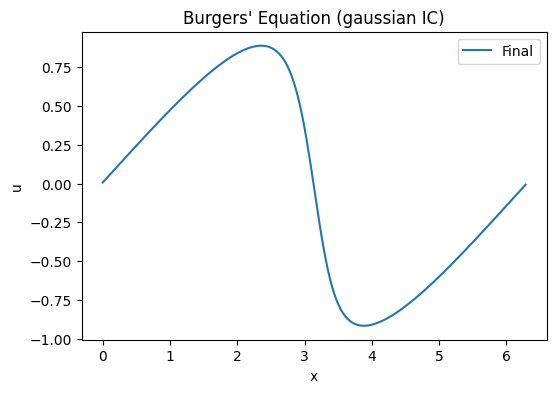

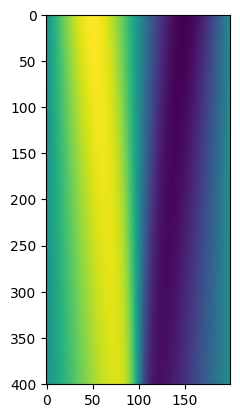

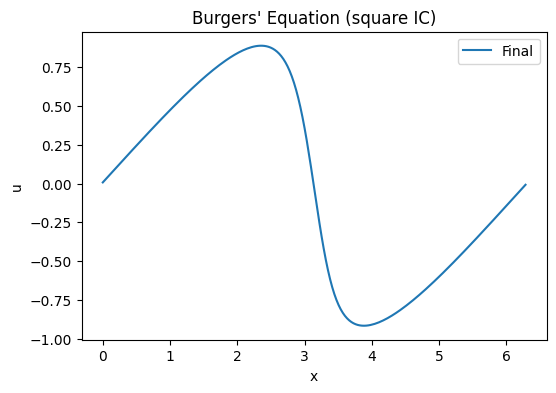

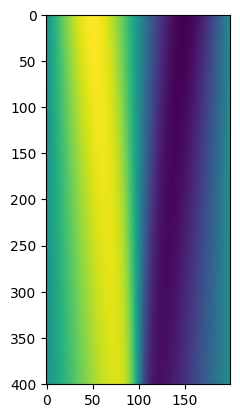

In [2]:
def burgers_solver(nx=101, nt=200, L=2*np.pi, T=1.0, nu=0.01, u0 = np.sin):
    """
    Solve 1D viscous Burgers' equation using finite differences.

    Parameters:
        nx   : number of spatial grid points
        nt   : number of time steps
        L    : domain length
        T    : final time
        nu   : viscosity
        init_cond : type of initial condition ("sine", "gaussian", "square")
    """
    dx = L / (nx - 1)
    dt = T / nt

    # Grid
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt + 1)
    u = u0(x).copy()
    U = []
    U.append(u)
    # Time stepping
    for n in range(nt):
        un = u.copy()

        # Convection (upwind scheme)
        convection = un * (un - np.roll(un, 1)) / dx

        # Diffusion (central scheme)
        diffusion = nu * (np.roll(un, -1) - 2*un + np.roll(un, 1)) / dx**2

        # Update
        u = un - dt * convection + dt * diffusion
        U.append(u)

    return t, x, u, np.array(U)


if __name__ == "__main__":
    # Run solver for different initial conditions
    for cond in ["sine", "gaussian", "square"]:
        t, x, u, U = burgers_solver(nu = 0.1, nx = 200, nt = 400, u0 = np.sin)
        plt.figure(figsize=(6,4))
        plt.plot(x, u, label="Final")
        plt.title(f"Burgers' Equation ({cond} IC)")
        plt.xlabel("x")
        plt.ylabel("u")
        plt.legend()
        plt.figure()
        plt.imshow(U)


(401, 200)


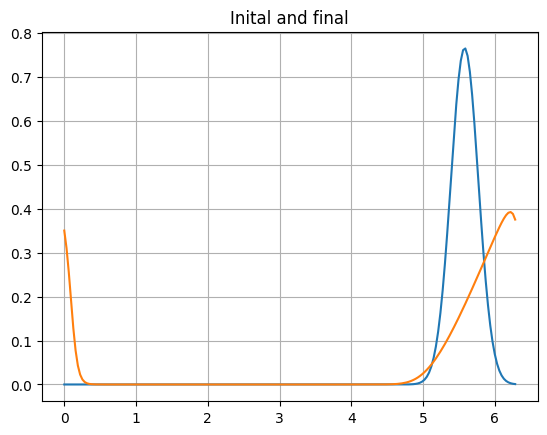

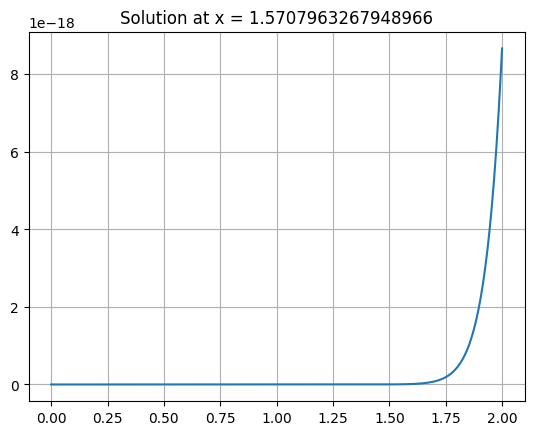

In [3]:
L = 2*np.pi
T = 2.0
nx = 200
nt = 400 
nu = 0.01
def gaussian(x, mu = L/2, sigma = 1):
    sigma = np.random.random(1)*2
    mu = np.random.random_sample(1)*L
    return 1/np.sqrt(2*np.pi * sigma) * np.exp(- ((x-mu)/sigma)**2)

def sinusoidal(x):
    return np.sin(np.random.random(1)*10 * x)
t, x, u, U = burgers_solver(nu = nu, nx = nx, nt = nt, L = L, u0 = gaussian, T = T)
print(np.shape(U))
idx =50

plt.title(f'Inital and final')
plt.plot(x, U[0,:], label = f'inital')
plt.plot(x, U[-1,:], label = f'final')
plt.grid(True)
plt.figure()
plt.title(f'Solution at x = {idx*L/nx}')
plt.plot(t, U[:,idx])
plt.grid(True)


In [4]:
def safe_burgers_solver(**kwargs):
    """Wrapper to handle overflow errors and restart with smaller dt."""
    try:
        return burgers_solver(**kwargs)
    except RuntimeWarning:
        print("Overflow detected! Restarting with smaller time step...")
        # Increase number of timesteps to reduce dt
        kwargs["nt"] *= 2
        return safe_burgers_solver(**kwargs)

In [5]:
# DATA GENERATION
nu_range = [1e-10, 1e-1]
L = 2*np.pi
T = 2.0
nx = 100
nt = 200 
nu = 0.1

# t data generation
ntrajectories = nt
stacked_time = np.tile(t, (ntrajectories, 1))
U = np.zeros((ntrajectories, nt+1, nx))
stacked_time = np.tile(t, (ntrajectories, 1))
for i in range(np.shape(U)[0]):
  nus_test = (nu_range[1] - nu_range[0]) * np.random.rand() + nu_range[0]
  print(nus_test)
  t,x,_,U[i] = safe_burgers_solver(nx = nx, nt = nt, L = L, T = T, nu = nus_test, u0 = sinusoidal)


0.09326056399538969
0.03882355467257471
0.06573675858136702
0.09642384192858187
0.04552052857543696
0.0041717973777033145
0.0003171117752123129
0.06109143330559647
0.030011500544452164
0.06663921052369368


/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:27: RuntimeWarning: overflow encountered in multiply
  convection = un * (un - np.roll(un, 1)) / dx
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:33: RuntimeWarning: invalid value encountered in subtract
  u = un - dt * convection + dt * diffusion
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:33: RuntimeWarning: invalid value encountered in add
  u = un - dt * convection + dt * diffusion
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:27: RuntimeWarning: overflow encountered in divide
  convection = un * (un - np.roll(un, 1)) / dx
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:27: RuntimeWarning: invalid value encountered in subtract
  convection = un * (un - np.roll(un, 1)) / dx
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_53172/3840158237.py:30: RuntimeWarning: inva

0.04682704066061579
0.09160313868164077
0.02776973740265103
0.015474499956169667
0.032424320708524794
0.05131412882928515
0.006739574759182391
0.04688992684575968
0.09226117768062071
0.09290876772615653
0.08020496904995629
0.048212907575240396
0.027667928433378234
0.01050746021532895
0.06485080217028695
0.010386594295153062
0.007810332004089217
0.09590869876535263
0.09540211444754383
0.026342439121782708
0.03762683155561441
0.06670733017522018
0.097356447400457
0.044137199800273835
0.06535675844225092
0.06692318027000767
0.0783364457576869
0.009706066940069853
0.0025222519176279936
0.08571083370723871
0.019410918485410395
0.023518365551680628
0.014516351798867495
0.009778801198787782
0.014451972898832158
0.07292148174440329
0.04435385131998624
0.017577376635703225
0.027189770665403953
0.03660145925643701
0.08815026631571116
0.010084644689729453
0.09564520366409537
0.013150630968368835
0.050054445272811623
0.05681818722621909
0.06214417612620143
0.0384780746405999
0.09573928761154546
0.

[132 309 341 196 246  60 155 261 141 214  37 134 113 348  12  59 293 140
 206 199 176 268 124 344 175 313  78  15 286 102 170 303 334 225  65  76
  90 173 179 399 100 322   6   1 297  54 374 255 158 233 247 144 294 171
 280 318  52  10  26  45  74 272   4 354 191 371 145   5 154 310   7 260
  68  20 107  14 363 304 361 329 336  64  55 106 300 229 122 373 395 325
 380 253  56   8 190 146 135 390 264 364 250  63 312 159 283 340  81 349
 153 295  96  89 296  21 365 216 259  49 238 343  92 223 234 232 377 142
  22 252 350 168 150 393  66 240 218 101 311 194 326  17 164 186  30 114
 263 103 358 245 235 116 330 120 289 112 215 136 275 126 198 299 281 133
  33 378 162  34 231  97  85  61 167 282 200 391 230 287 108  46 320 396
 224  73 137 381 220 210  29 181 360 271  51 328 352  27   2 217 156 212
 376 221 138 236 219 274 278 307 239  35 204 392  67  24 332  44 241 129
  93 111 166 389 383 342  40  18 284  79 249 394  71  13 367 213 385 388
 228 160 104 161  83 189 397 118 254 188 208 375 11

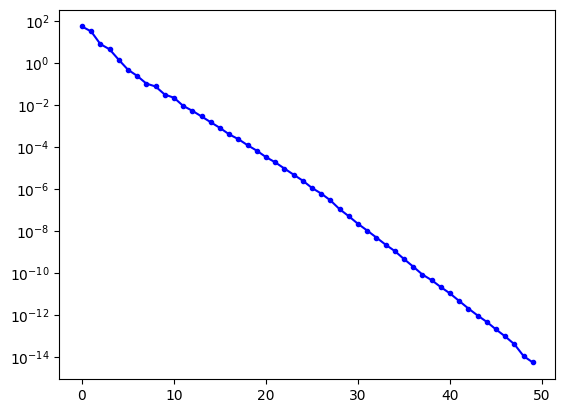

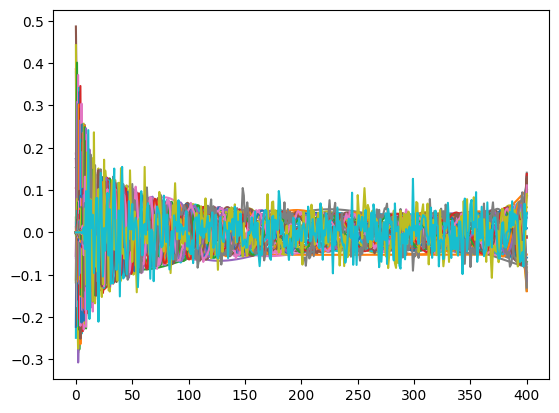

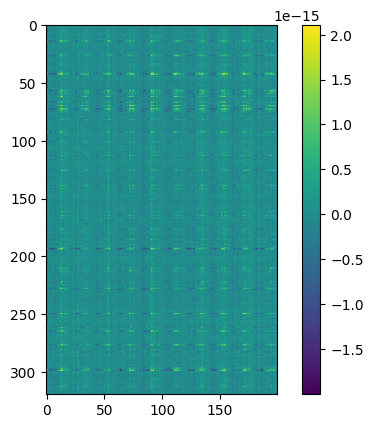

In [9]:
from sklearn.utils.extmath import randomized_svd
L = 2*np.pi
T = 2.0
nx = 200
nt = 400 
nu = 0.1
n_instances = 2 

npixels = 3
pixels_coordinates = [int(1/4 * nx), int(1/2 * nx), int(3/4 * nx)]

def sinusoidal(x):
    return np.sin(10 * x)

t,x,_,U = safe_burgers_solver(nx = nx, nt = nt, L = L, T = T, nu = nus_test, u0 = sinusoidal)

k = 50 # Number of POD modes

Y, S, V = randomized_svd(U, n_components = k)
U_tilde = U @ V.T

U_sensor = np.array([U[:, pixels_coordinates]])


np.random.seed(0)

ntrain = round(0.8 * nt)

idx_train = np.random.choice(nt, size = ntrain, replace = False)
mask = np.ones(nt)
mask[idx_train] = 0
idx_valid_test = np.arange(0, nt)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

print(idx_train)
print(idx_valid)
print(idx_test)

plt.plot(S, 'b.-')
plt.yscale('log')
plt.figure()
plt.plot(Y)
plt.figure()
print(np.shape(U_tilde), np.shape(V))
plt.imshow(U_tilde[idx_train] @ V - U[idx_train])
plt.colorbar()

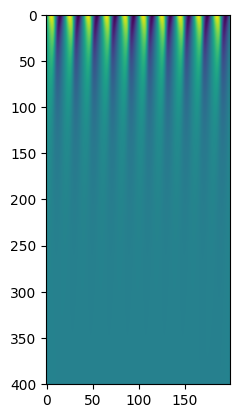

In [10]:

plt.imshow(U)

In [11]:
from utils.processdata import Padding, TimeSeriesDataset

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 25

data_in = Padding(torch.from_numpy(U_sensor).float(), lag).to(device)
shape_U = np.shape(U)
data_out = torch.from_numpy(U_tilde).float().to(device)
data_out = Padding(torch.from_numpy(np.array([U_tilde])), 1).squeeze(1).to(device)
print(np.shape(data_in))
print(np.shape(data_out))

train_dataset = TimeSeriesDataset(data_in[idx_train], data_out[idx_train])
valid_dataset = TimeSeriesDataset(data_in[idx_valid], data_out[idx_valid])
test_dataset = TimeSeriesDataset(data_in[idx_test], data_out[idx_test])


torch.Size([401, 25, 3])
torch.Size([401, 50])


In [12]:
print(np.shape(torch.from_numpy(U_sensor).float()))
print(np.shape(data_in))
print(np.shape(data_out))


print(np.shape(train_dataset.X))
print(np.shape(train_dataset.Y))

print(np.shape(valid_dataset.X))
print(np.shape(valid_dataset.Y))


print(np.shape(test_dataset.X))
print(np.shape(test_dataset.Y))

torch.Size([1, 401, 3])
torch.Size([401, 25, 3])
torch.Size([401, 50])
torch.Size([320, 25, 3])
torch.Size([320, 50])
torch.Size([40, 25, 3])
torch.Size([40, 50])
torch.Size([40, 25, 3])
torch.Size([40, 50])


In [13]:
U[idx_test]

array([[ 0.05175884,  0.1619766 ,  0.26793385, ..., -0.28886764,
        -0.1747999 , -0.06090849],
       [ 0.04423253,  0.14221816,  0.23611996, ..., -0.2595259 ,
        -0.15770533, -0.05613093],
       [ 0.03695432,  0.1233799 ,  0.20573114, ..., -0.23229048,
        -0.14189868, -0.0518501 ],
       ...,
       [-0.11084796, -0.11107613, -0.11155586, ..., -0.11202767,
        -0.11130705, -0.110916  ],
       [-0.11151324, -0.1117052 , -0.11210887, ..., -0.11252183,
        -0.11190499, -0.1115716 ],
       [-0.11207722, -0.11223736, -0.11257791, ..., -0.11295437,
        -0.11241998, -0.11213067]])

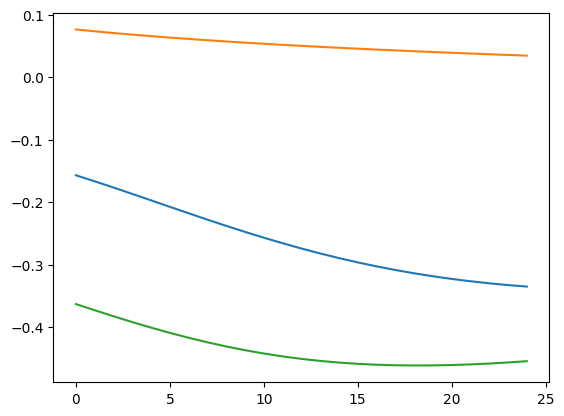

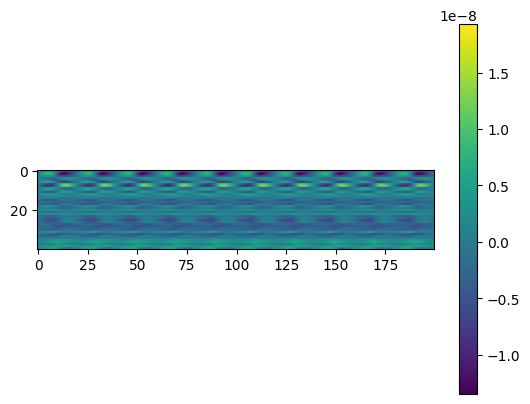

In [14]:
plt.plot(test_dataset.X[2])
plt.figure()
plt.imshow(torch.detach(test_dataset.Y).numpy() @ V - U[idx_test] )
plt.colorbar()

In [15]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(npixels, np.shape(data_out)[1], hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 200, lr = 1e-3, verbose = True, patience = 100, step_size = 100)

Training done: Training loss = 1.37% 	 Validation loss = 1.26%       	 learning rate = 1e-051


In [16]:
from utils.processdata import mre, num2p # Error metrics and format

y_hat = shred.forward(test_dataset.X)
y_test = test_dataset.Y
print(mre(y_test, y_hat  ), num2p(mre(y_test , y_hat )))

tensor(0.0124, grad_fn=<MeanBackward0>) 1.24%


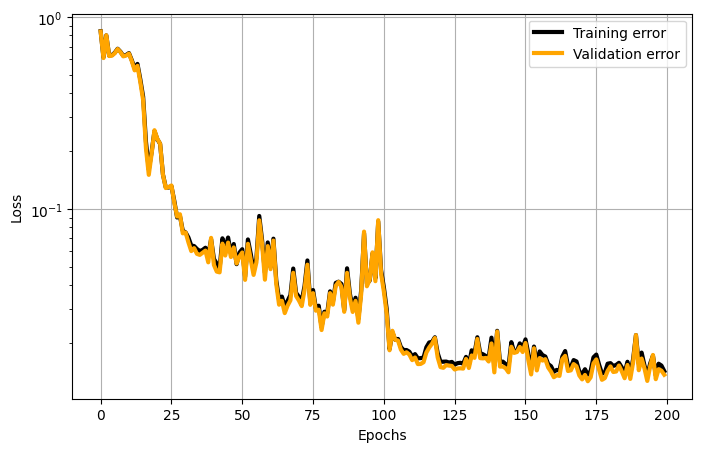

In [17]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(valid_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

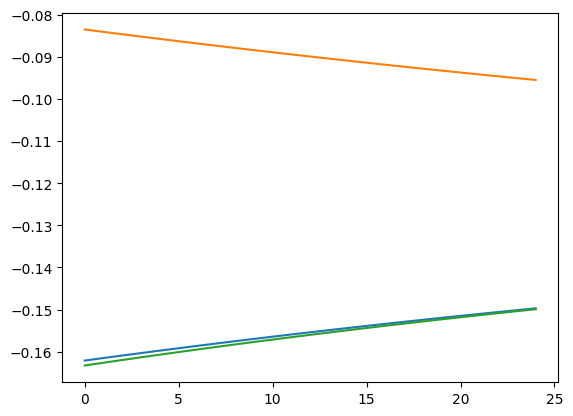

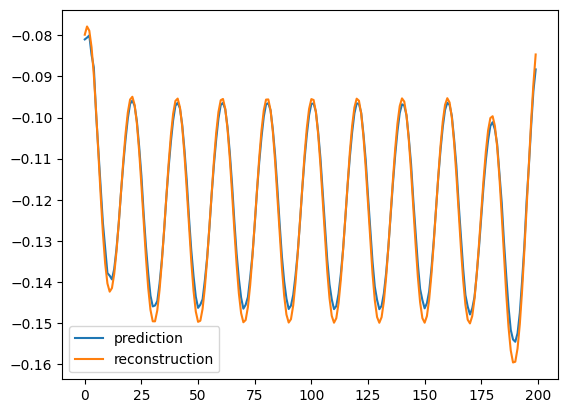

In [18]:
idx = 20
plt.plot(test_dataset.X[idx])

plt.figure()
plt.plot(torch.detach(y_hat).numpy()[idx] @ V, label = 'prediction')
plt.plot(torch.detach(y_test).numpy()[idx] @ V, label = 'reconstruction' )
plt.legend()

1.24%


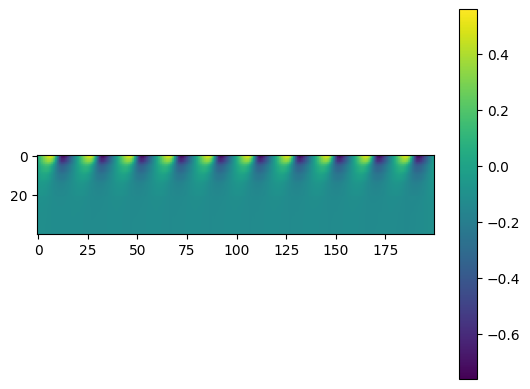

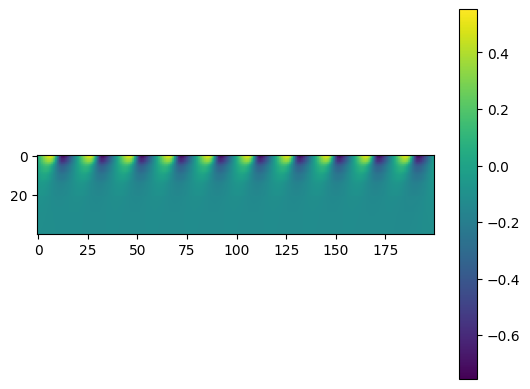

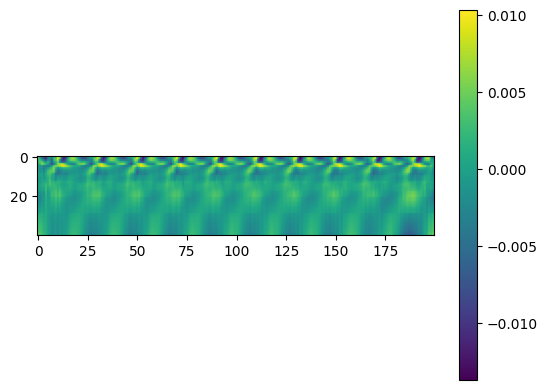

In [19]:
print(num2p(mre(torch.from_numpy(U[idx_test] ), torch.from_numpy(torch.detach(y_hat ).numpy() @ V ))))
plt.imshow(torch.from_numpy(torch.detach(y_hat ).numpy() @ V) )
plt.colorbar()
plt.figure()
plt.imshow(U[idx_test] )
plt.colorbar()
plt.figure()
plt.imshow(torch.detach(y_hat).numpy() @ V -U [idx_test] )
plt.colorbar()

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch

class BranchTrunkDataset(Dataset):
    """
    PyTorch Dataset for DeepONet or branch/trunk networks.
    
    Each item is ((trunk_input, branch_input), target)
    """
    def __init__(self, trunk_data, branch_data, targets):
        """
        trunk_data: torch.Tensor of shape (N, trunk_features)
        branch_data: torch.Tensor of shape (N, branch_features)
        targets: torch.Tensor of shape (N, output_features)
        """
        assert len(trunk_data) == len(branch_data) == len(targets), \
            "Trunk, branch, and targets must have the same number of samples."
        
        self.trunk_data = trunk_data
        self.branch_data = branch_data
        self.Y = targets

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        trunk_input = self.trunk_data[idx]
        branch_input = self.branch_data[idx]
        target = self.Y[idx]
        
        return (trunk_input, branch_input), target

In [24]:
device = 'cpu'
lag = 100
# Trunk input: sequences of sensors
data_in = Padding(torch.from_numpy(U_sensor).float(), lag).to(device)

train_branch = Padding(data_in[idx_train], lag).to(device)  # (num_samples, lag, 1)
valid_branch = Padding(data_in[idx_valid], lag).to(device)
test_branch = Padding(data_in[idx_test], lag).to(device)

# Branch input: e.g., stacked time
train_trunk = torch.tensor(t, dtype=torch.float32).view(-1, 1).to(device)  # (num_samples, 1)
valid_trunk = torch.tensor(t, dtype=torch.float32).view(-1, 1).to(device)
test_trunk = torch.tensor(t, dtype=torch.float32).view(-1, 1).to(device)

train_data_out = Padding(torch.tensor([U[idx_train]], dtype = torch.float32), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.tensor([U[idx_valid]], dtype = torch.float32), 1).squeeze(1).to(device)
test_data_out = Padding(torch.tensor([U[idx_test]], dtype = torch.float32), 1).squeeze(1).to(device)

torch.Size([40, 200])